# Titanic - Machine Learning from Disaster | Kaggle Competition
- Link to competition [here](https://www.kaggle.com/c/titanic/overview)

## Contents<a class="anchor" id="contents"></a>
1. [Data Exploration](#data_exploration)
    1. [Initial Exploration](#initial_exploration)
        1. [Variable Dictionary](#variable_dictionary)
        2. [Survival](#survival)
        3. [NaN Values](#nan_values)
    2. [Categorical Features](#categorical_features)
        1. [Name](#name)
        2. [Sex](#sex)
        3. [Cabin](#cabin)
        4. [Embarked](#embarked)
    3. [Continuous Features](#continuous_features)
        1. [Correlation & Significance](#correlation_significance)
        2. [Pclass](#pclass)
        3. [Age](#age)
        4. [Sibsp & Parch](#sibsp_parch)
        5. [Family Matters](#family_matters)
        6. [Fare](#fare)
    4. [Further Cleaning](#further_cleaning)
        1. [Capping](#capping)
        2. [Transforming Skewed Features](#transforming_skewed_features)
2. [Creating Data Files](#creating_data_files)
    1. [Dropping Columns](#dropping_columns)
    2. [Scaling](#scaling)
    3. [Splitting Up Data](#splitting_up_data)
3. [Training Models](#training_models)
    1. [Logistic Regression](#logistic_regression)
    2. [Support Vector Machine](#support_vector_machine)
    3. [Multilayer Perceptron](#multilayer_perceptron)
    4. [Random Forest](#random_forest)
    5. [Gradient Boosting](#gradient_boosting)
5. [Model Selection](#model_selection)
    1. [Evaluation Statistics](#evaluation_statistics)
5. [Final Training and Submission](#final_training_and_submission)
6. [Results](#results)

In [2]:
# basic imports
import numpy as np
import pandas as pd
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# visualization
import seaborn as sns 
import matplotlib.pyplot as plt

# statistics
from scipy import stats
from statsmodels.graphics.gofplots import qqplot

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# splitting data
from sklearn.model_selection import train_test_split

# cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# view parameters
from sklearn import set_config
set_config(print_changed_only=False)

# models
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

# model selection
from time import time
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [3]:
np.linspace(0.1, 1.0, 10, endpoint=True)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

# 1) Data Exploration <a class="anchor" id="data_exploration"></a>
[To contents](#contents)

In [1483]:
# import training data
train = pd.read_csv('data/train.csv')
# import test data
test = pd.read_csv('data/test.csv')
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## A) Initial Exploration<a class="anchor" id="initial_exploration"></a>
[To contents](#contents)

### a) Variable Dictionary <a class="anchor" id="variable_dictionary"></a>
[To contents](#contents)
- **Name** (str) - Name of the passenger
- **Pclass** (int) - Ticket class
- **Sex** (str) - Sex of the passenger
- **Age** (float) - Age in years
- **SibSp** (int) - Number of siblings and spouses aboard
- **Parch** (int) - Number of parents and children aboard
- **Ticket** (str) - Ticket number
- **Fare** (float) - Passenger fare
- **Cabin** (str) - Cabin number
- **Embarked** (str) - Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

### b) Survival <a class="anchor" id="survival"></a>
[To contents](#contents)

In [1484]:
print('Training set size: ', len(train))
print('Training set survived: ', sum(train['Survived']))
print('Training set dead: ', len(train) - sum(train['Survived']))

Training set size:  891
Training set survived:  342
Training set dead:  549


### c) NaN Values<a class="anchor" id="nan_values"></a>
[To contents](#contents)

In [1485]:
print(train.isnull().sum())
print(test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


- There are four features with `NaN` values: `Age`, `Fare`, `Cabin`, `Embarked`
- We will deal with these missing values later

## B) Categorical Features <a class="anchor" id="categorical_features"></a>
[To contents](#contents)
- Includes `Name`, `Sex`, `Cabin`, and `Embarked`

In [1486]:
# explore the number of unique values for each feature
for col in ['Survived', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']:
    print('{}: {} unique values'.format(col, train[col].nunique()))

Survived: 2 unique values
Name: 891 unique values
Sex: 2 unique values
Ticket: 681 unique values
Cabin: 147 unique values
Embarked: 3 unique values


### a) Name <a class="anchor" id="name"></a>
[To contents](#contents)
- Create a `Title` feature by parsing passenger name
- Title may be a proxy for status and could indicate survival

In [1487]:
# parse passenger name
whole = train.append(test)
whole['Title'] = whole['Name'].str.extract(r'([A-Za-z]+)\.', expand=False)
whole['Title'].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Major         2
Ms            2
Lady          1
Sir           1
Mme           1
Don           1
Capt          1
Countess      1
Jonkheer      1
Dona          1
Name: Title, dtype: int64

In [1488]:
# replace title with common titles
common_title = ['Mr', 'Mrs', 'Master']
whole['Title'].replace(['Lady', 'Miss', 'Ms', 'Mlle', 'Mme'], 'Mrs', inplace=True)
whole['Title'].replace(['Sir', 'Rev'], 'Mr', inplace=True)
whole['Title'][~whole['Title'].isin(common_title)] = 'Others'

# convert back to train and test sets
train = whole[:len(train)]
test = whole[len(train):]

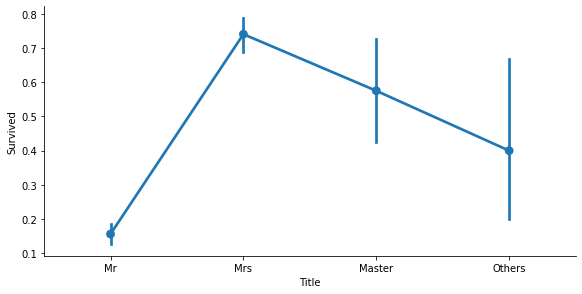

In [1489]:
sns.catplot(x='Title', y='Survived', data=train, kind='point', height=4, aspect=2);

In [1490]:
# convert categorical to numerical

# train data
train['Title_Code'] = train['Title'].map({'Mr':0, 'Mrs':1, 'Master':2, 'Others':3}).astype('int')
# test data
test['Title_Code'] = test['Title'].map({'Mr':0, 'Mrs':1, 'Master':2, 'Others':3}).astype('int')

### b) Sex <a class="anchor" id="sex"></a>
[To contents](#contents)
- Change `female` to `1` and `male` to `0`
- Sex is correlated with title

In [1491]:
def sex(s):
    if s == 'female':
        return 1
    if s == 'male':
        return 0

# train data
train['Sex'] = train['Sex'].apply(sex)
# test data
test['Sex'] = test['Sex'].apply(sex)

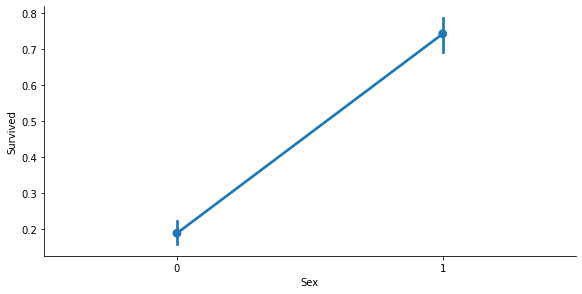

In [1492]:
sns.catplot(x='Sex', y='Survived', data=train, kind='point', height=4, aspect=2);

- Sex is a major predictor of survivability
- Males have significantly lower survival rates than females

### c) Cabin <a class="anchor" id="cabin"></a>
[To contents](#contents)

In [1493]:
train.groupby(train['Cabin'].isnull()).mean()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title_Code
Cabin,,,,,,,,,
False,455.401961,0.666667,1.196078,0.475490,35.829297,0.441176,0.436275,76.141504,0.651961
True,443.208151,0.299854,2.639010,0.315866,27.555293,0.547307,0.365357,19.157325,0.442504


- Although there are many `NaN` values for `Cabin`, the presence of a `NaN` seems to indicate higher survival rates
- We can replace the `NaN` values with `0`, indicating the absence of info, and all other values with `1`, indicating the presence of info

In [1494]:
# train data
train['Cabin'] = np.where(train['Cabin'].isnull(), 0, 1)
# test data
test['Cabin'] = np.where(test['Cabin'].isnull(), 0, 1)

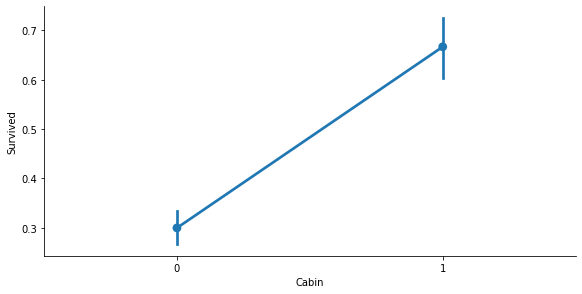

In [1495]:
sns.catplot(x='Cabin', y='Survived', data=train, kind='point', height=4, aspect=2);

### d) Embarked <a class="anchor" id="embarked"></a>
[To contents](#contents)

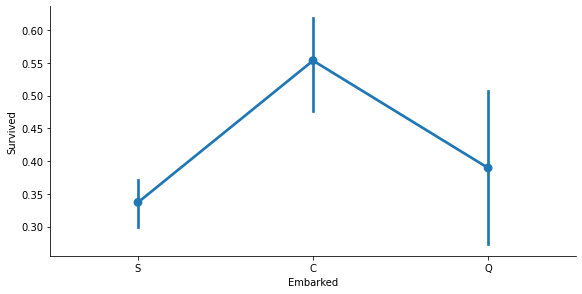

In [1496]:
sns.catplot(x='Embarked', y='Survived', data=train, kind='point', height=4, aspect=2);

- People embarking from Cherbourg seem to have a higher survival rate than those embarking from Southampton or Queenstown
- This could be due to other predictors
- Compare this with the other two variables we have looked at so far, `Sex` and `Cabin`, which are meaningful predictors

In [1497]:
train.pivot_table('Survived', index='Sex', columns='Embarked', aggfunc='count')

Embarked,C,Q,S
Sex,,,
0,95,41,441
1,73,36,203


In [1498]:
train.pivot_table('Survived', index='Cabin', columns='Embarked', aggfunc='count')

Embarked,C,Q,S
Cabin,,,
0,99,73,515
1,69,4,129


- Cherbourg has a much higher proportion of females than Southampton, potentially explaining the higher survival rates compared to Southampton
- Cherbourg also has a much higher proportion of passengers with cabin data, potentially explaining the higher survival rates compared to Queenstown

In [1499]:
train['Embarked'].fillna('S', inplace=True)

In [1500]:
# convert categorical to numerical

# train data 
train['Embarked'] = train['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype('int')
# test data
test['Embarked'] = test['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype('int')

## C) Continuous Features<a class="anchor" id="continuous_features"></a>
[To contents](#contents)
- Includes `Pclass`, `Age`, `SibSp`, `Parch`, `Fare`

In [1501]:
cat_features = ['Sex', 'Cabin', 'Title_Code', 'Title', 'Embarked']
train_cont = train.drop(columns=cat_features)
train_cont.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### a) Correlation & Significance<a class="anchor" id="correlation_significance"></a>
[To contents](#contents)

In [1502]:
# correlation matrix: look for high absolute value
train_cont.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


- `Fare` (0.257307) and `Pclass` (-0.338481) have the most significant correlations with survival
- They are also significantly correlated with each other (-0.549500)

In [1503]:
# groups by survive and did not survive
def describe_cont_feature(feature):
    print('\n*** Results for {} ***'.format(feature))
    print(train_cont.groupby('Survived')[feature].describe())
    print(ttest(feature))

# perform t-test and calculate p-value
def ttest(feature):
    survived = train_cont[train_cont['Survived']==1][feature]
    not_survived = train_cont[train_cont['Survived']==0][feature]
    tstat, pval = stats.ttest_ind(survived, not_survived, equal_var=False)
    print('t-statistic: {:.1f}, p-value: {:.3}'.format(tstat, pval))

In [1504]:
# look at the distribution of each feature for survived and did not survive
for feature in ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']:
    describe_cont_feature(feature)


*** Results for Pclass ***
          count      mean       std  min  25%  50%  75%  max
Survived                                                    
0.0       549.0  2.531876  0.735805  1.0  2.0  3.0  3.0  3.0
1.0       342.0  1.950292  0.863321  1.0  1.0  2.0  3.0  3.0
t-statistic: -10.3, p-value: 2.91e-23
None

*** Results for Age ***
          count       mean        std   min   25%   50%   75%   max
Survived                                                           
0.0       424.0  30.626179  14.172110  1.00  21.0  28.0  39.0  74.0
1.0       290.0  28.343690  14.950952  0.42  19.0  28.0  36.0  80.0
t-statistic: nan, p-value: nan
None

*** Results for SibSp ***
          count      mean       std  min  25%  50%  75%  max
Survived                                                    
0.0       549.0  0.553734  1.288399  0.0  0.0  0.0  1.0  8.0
1.0       342.0  0.473684  0.708688  0.0  0.0  0.0  1.0  4.0
t-statistic: -1.2, p-value: 0.233
None

*** Results for Parch ***
          count

- P-value quantifies the probability of observing as or more extreme values assuming the null hypothesis, that the samples are drawn from populations with the same population means, is true
- P-value smaller than a chosen threshold (e.g. 5% or 1%) indicates that our observation is unlikely to have occurred by chance
- Smallest p-values are `Pclass` (2.91e-23) and `Fare` (2.7e-11)

### b) Pclass<a class="anchor" id="pclass"></a>
[To contents](#contents)
- `Pclass` appears to be an excellent indicator of survival

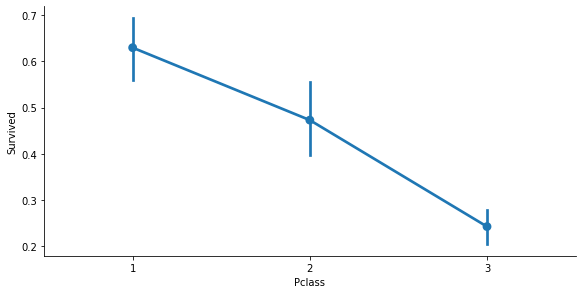

In [1505]:
sns.catplot(x='Pclass', y='Survived', data=train, kind='point', height=4, aspect=2);

### c) Age <a class="anchor" id="age"></a>
[To contents](#contents)

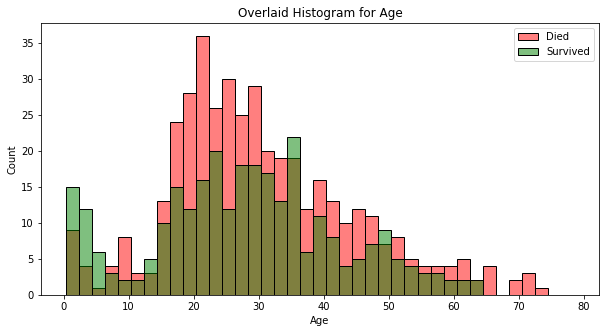

In [1506]:
died = train[train['Survived'] == 0]['Age'].dropna()
survived = train[train['Survived'] == 1]['Age'].dropna()
xmin = min(min(died), min(survived))
xmax = max(max(died), max(survived))

plt.figure(figsize=(10, 5))
sns.histplot(died, color='r', alpha = 0.5, kde=False, bins=np.arange(xmin, xmax, 2))
sns.histplot(survived, color='g', alpha = 0.5, kde=False, bins=np.arange(xmin, xmax, 2))
plt.legend(['Died', 'Survived'])
plt.title('Overlaid Histogram for Age')
plt.show()

- To replace missing values, we will look at median age by title

In [1507]:
# get the age median by title
age_median_by_title = train.groupby('Title')['Age'].median()
age_median_by_title

Title
Master     3.5
Mr        30.0
Mrs       27.0
Others    47.0
Name: Age, dtype: float64

In [1508]:
for title in age_median_by_title.index:
    # train data
    train['Age'][(train['Age'].isnull()) & (train['Title'] == title)] = age_median_by_title[title]
    # test data
    test['Age'][(test['Age'].isnull()) & (test['Title'] == title)] = age_median_by_title[title]

### d) SibSp & Parch <a class="anchor" id="sibsp_parch"></a>
[To contents](#contents)

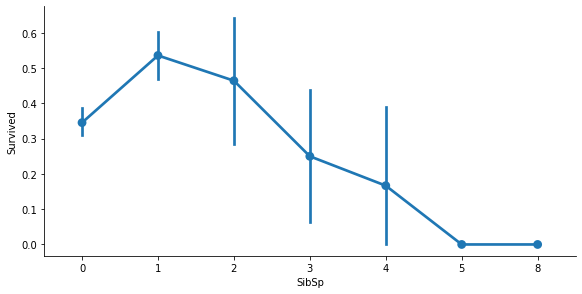

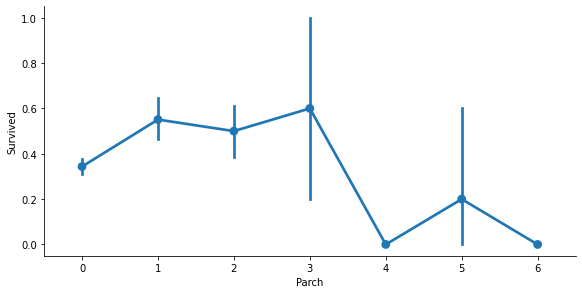

In [1509]:
sns.catplot(x='SibSp', y='Survived', data=train, kind='point', height=4, aspect=2)
sns.catplot(x='Parch', y='Survived', data=train, kind='point', height=4, aspect=2);

- In general, larger family size corresponds to lower survival rate
- Combine `Parch` and `SibSp` into a `FamilyCount` feature

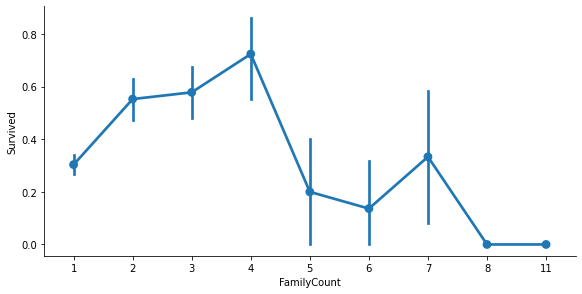

In [1510]:
# train data
train['FamilyCount'] = train['Parch'] + train['SibSp'] + 1
# test data
test['FamilyCount'] = test['Parch'] + test['SibSp'] + 1

sns.catplot(x = 'FamilyCount', y = 'Survived', data = train, kind='point', height=4, aspect=2);

### e) Family Matters  <a class="anchor" id="family_matters"></a>
[To contents](#contents)
- Families can survive better together, since they help each other
- Children have first priority on lifeboats, so find families with children
- To find families, check surnames and tickets
- As shown below, people with same surnames have similar ticket names

In [1511]:
train[['Name', 'Ticket']].sort_values('Name').head(10)

,Name,Ticket
845,"Abbing, Mr. Anthony",C.A. 5547
746,"Abbott, Mr. Rossmore Edward",C.A. 2673
279,"Abbott, Mrs. Stanton (Rosa Hunt)",C.A. 2673
308,"Abelson, Mr. Samuel",P/PP 3381
874,"Abelson, Mrs. Samuel (Hannah Wizosky)",P/PP 3381
365,"Adahl, Mr. Mauritz Nils Martin",C 7076
401,"Adams, Mr. John",341826
40,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",7546
855,"Aks, Mrs. Sam (Leah Rosen)",392091
207,"Albimona, Mr. Nassef Cassem",2699


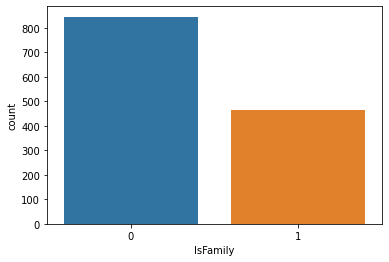

In [1512]:
# combine test and train and create new columns for surname, ticket prefix, and a combination
whole = train.append(test)
whole['Surname'] = whole['Name'].str.extract(r'([A-Za-z]+),', expand=False)
whole['TicketPref'] = whole['Ticket'].str.extract(r'(.*\d)', expand=False)
whole['SurTix'] = whole['Surname'] + whole['TicketPref']
whole['IsFamily'] = whole['SurTix'].duplicated(keep=False)*1

# plot shows 2/3 people travel with family
sns.countplot(whole['IsFamily'])
plt.show()

In [1513]:
# create child (age < 13) column and create a list of familites with a child
whole['Child'] = whole['Age'].map(lambda x: 1 if x <= 13 else 0)
family_with_child = whole[(whole['IsFamily']==1) & (whole['Child']==1)]['SurTix'].unique()
print('There are {} families with children.'.format(len(family_with_child)))

There are 59 families with children.


In [1514]:
# encode the families with children with a unique family id
whole['FamilyId'] = 0
x = 1
for tix in family_with_child:
    whole.loc[whole['SurTix'] == tix, ['FamilyId']] = x
    x += 1

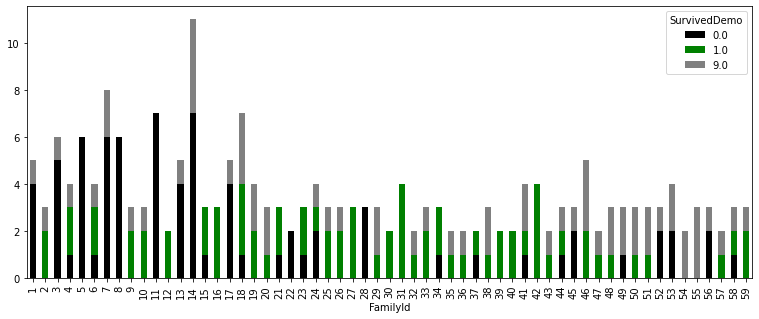

In [1515]:
# for each family: black shows died, green shows survived, grey is no data (from test set)
whole['SurvivedDemo'] = whole['Survived'].fillna(9)
pd.crosstab(whole['FamilyId'], whole['SurvivedDemo']).drop([0]).plot(kind='bar', stacked=True, color=['black','g','grey'], figsize=(13,5))
plt.show()

In [1516]:
whole['Family_Matters'] = 1 
# how many people survived for each family id
survived_by_familyid = whole.groupby('FamilyId')['Survived'].sum()

# loop through all family ids, excluding 0, which indicates lone traveller
for i in range(1, len(family_with_child)+1):
    # if whole family didn't die, increase chances of survival
    if survived_by_familyid[i] >= 1:
        whole.loc[whole['FamilyId']==i, ['Family_Matters']] = 2
    # if whole family died, decrease chances of survival
    elif survived_by_familyid[i] == 0:
        whole.loc[whole['FamilyId']==i, ['Family_Matters']] = 0

# convert back to train and test sets
train = whole[:len(train)]
test = whole[len(train):]

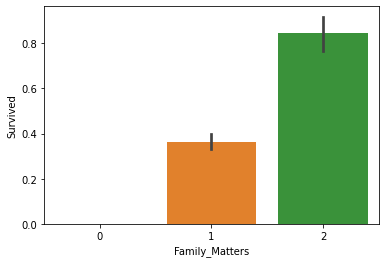

In [1517]:
sns.barplot(x='Family_Matters', y='Survived', data=train)
plt.show()

### f) Fare  <a class="anchor" id="fare"></a>
[To contents](#contents)

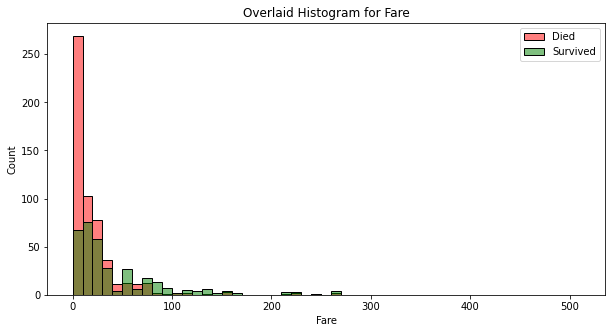

In [1518]:
died = train[train['Survived'] == 0]['Fare'].dropna()
survived = train[train['Survived'] == 1]['Fare'].dropna()
xmin = min(min(died), min(survived))
xmax = max(max(died), max(survived))

plt.figure(figsize=(10, 5))
sns.histplot(died, color='r', alpha = 0.5, kde=False, bins=np.arange(xmin, xmax, 10))
sns.histplot(survived, color='g', alpha = 0.5, kde=False, bins=np.arange(xmin, xmax, 10))
plt.legend(['Died', 'Survived'])
plt.title('Overlaid Histogram for Fare')
plt.show()

- Fare may be less of a good indicator than is suggested by the averages, because there are a few outliers that raise the average for people who survived
- At lower fares, more people died than survived, while at higher fares, more or all people survived
- There is only one missing value, simply replace it with the median of corresponding passengers
- There should be no more `NaN` values

In [1519]:
test[test['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title_Code,FamilyCount,Surname,TicketPref,SurTix,IsFamily,Child,FamilyId,SurvivedDemo,Family_Matters
152,1044,NaN,3,"Storey, Mr. Thomas",0,60.5,0,0,3701,NaN,...,0,1,Storey,3701,Storey3701,0,0,0,9.0,1


In [1520]:
# test data
whole = train.append(test)
median_fare = whole.groupby(['Pclass', 'Parch', 'SibSp'])['Fare'].median()[3][0][0]
print('Median Fare: {:.3f}'.format(median_fare))
test['Fare'].fillna(median_fare, inplace=True)

Median Fare: 7.854


- To better use `Fare` we will grouped into classes
- `Fare` will be grouped into 5 classes

In [1521]:
# train data
train['FareBin_5'] = pd.qcut(train['Fare'], 5)
# test data
test['FareBin_5'] = pd.qcut(test['Fare'], 5)

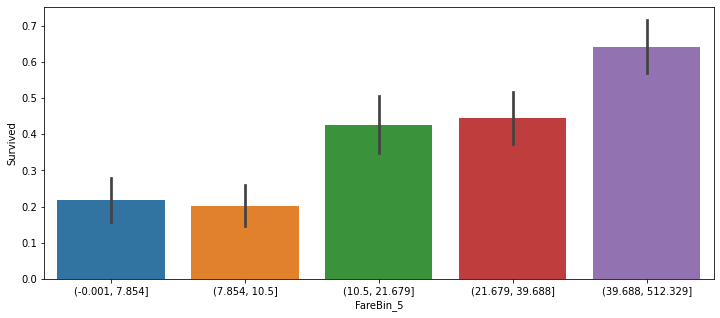

In [1522]:
fig = plt.figure(figsize=(12,5))
sns.barplot(x='FareBin_5', y='Survived', data=train)
plt.show()

In [1523]:
# convert categorical to numeric
le = LabelEncoder()
train['FareBin_Code_5'] = le.fit_transform(train['FareBin_5'])
test['FareBin_Code_5'] = le.fit_transform(test['FareBin_5'])

## D) Further Cleaning  <a class="anchor" id="further_cleaning"></a>
[To contents](#contents)

### a) Capping  <a class="anchor" id="capping"></a>
[To contents](#contents)
- Detect outliers in continuous features and remove them
- Check for >95%, >97.5%, >99.5%, 3sd
- Check `Age, Fare, FamilyCount`

In [1524]:
# see where outliers might be an issue
print(train[['Age', 'Fare', 'FamilyCount']].describe().loc['max'])
print(test[['Age', 'Fare', 'FamilyCount']].describe().loc['max'])

Age             80.0000
Fare           512.3292
FamilyCount     11.0000
Name: max, dtype: float64
Age             76.0000
Fare           512.3292
FamilyCount     11.0000
Name: max, dtype: float64


In [1525]:
# given a feature, detect outliers and store them
def detect_outlier(feature):
    outliers = []
    data = train[feature]
    mean = np.mean(data)
    std = np.std(data)
    print('\nOutlier caps for {}:'.format(feature))
    print('  --95p: {:.1f} / {} values'.format(data.quantile(.95), sum(data > data.quantile(.95))))
    print('  --97.5p: {:.1f} / {} values'.format(data.quantile(.975), sum(data > data.quantile(.975))))    
    print('  --99.5p: {:.1f} / {} values'.format(data.quantile(.995), sum(data > data.quantile(.995))))
    print('  --3sd: {:.1f} / {} values'.format(mean + 3*(std), sum(data > mean + 3*(std))))

In [1526]:
# determine what the upperbound should be for continuous features
for feat in ['Age', 'Fare', 'FamilyCount']:
    detect_outlier(feat)


Outlier caps for Age:
  --95p: 54.0 / 42 values
  --97.5p: 60.0 / 22 values
  --99.5p: 70.3 / 5 values
  --3sd: 68.9 / 7 values

Outlier caps for Fare:
  --95p: 112.1 / 45 values
  --97.5p: 153.5 / 22 values
  --99.5p: 263.0 / 3 values
  --3sd: 181.2 / 20 values

Outlier caps for FamilyCount:
  --95p: 6.0 / 25 values
  --97.5p: 7.0 / 13 values
  --99.5p: 11.0 / 0 values
  --3sd: 6.7 / 25 values


- Max `FamilyCount` is 10, which is reasonable
- Cap `Fare` and `Age` at 99.5%

In [1527]:
# cap features

# train data
train['Age_Capped'] = train['Age'].clip(upper=train['Age'].quantile(.995))
train['Fare_Capped'] = train['Fare'].clip(upper=train['Fare'].quantile(.995))
# test data
test['Age_Capped'] = test['Age'].clip(upper=test['Age'].quantile(.995))
test['Fare_Capped'] = test['Fare'].clip(upper=test['Fare'].quantile(.995))

In [1528]:
# check results of capping
print(train[['Age_Capped', 'Fare_Capped', 'FamilyCount']].describe().loc['max'])
print(test[['Age_Capped', 'Fare_Capped', 'FamilyCount']].describe().loc['max'])

Age_Capped      70.275
Fare_Capped    263.000
FamilyCount     11.000
Name: max, dtype: float64
Age_Capped      64.000000
Fare_Capped    262.946875
FamilyCount     11.000000
Name: max, dtype: float64


### b) Transforming Skewed Features  <a class="anchor" id="transforming_skewed_features"></a>
[To contents](#contents)
#### Box-Cox Power Transformation

 $$ y^x $$

| X    | Base Form           |           Transformation               |
|------|--------------------------|--------------------------|
| -2   | $$ y ^ {-2} $$           | $$ \frac{1}{y^2} $$      |
| -1   | $$ y ^ {-1} $$           | $$ \frac{1}{y} $$        |
| -0.5 | $$ y ^ {\frac{-1}{2}} $$ | $$ \frac{1}{\sqrt{y}} $$ |
| 0    | $$ y^{0} $$              | $$ log(y) $$             |
| 0.5  | $$ y ^ {\frac{1}{2}}  $$ | $$ \sqrt{y} $$           |
| 1    | $$ y^{1} $$              | $$ y $$                  |
| 2    | $$ y^{2} $$              | $$ y^2 $$                             |

**Process**

1. Determine what range of exponents to test
2. Apply each transformation to each value of your chosen feature
3. Use some criteria to determine which of the transformations yield the best distribution (QQ plot should ideally be linear along red line)

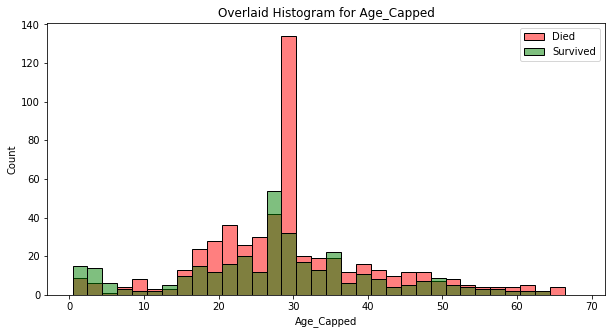

In [1529]:
died = train[train['Survived'] == 0]['Age_Capped'].dropna()
survived = train[train['Survived'] == 1]['Age_Capped'].dropna()
xmin = min(min(died), min(survived))
xmax = max(max(died), max(survived))

plt.figure(figsize=(10, 5))
sns.histplot(died, color='r', alpha = 0.5, kde=False, bins=np.arange(xmin, xmax, 2))
sns.histplot(survived, color='g', alpha = 0.5, kde=False, bins=np.arange(xmin, xmax, 2))
plt.legend(['Died', 'Survived'])
plt.title('Overlaid Histogram for Age_Capped')
plt.show()

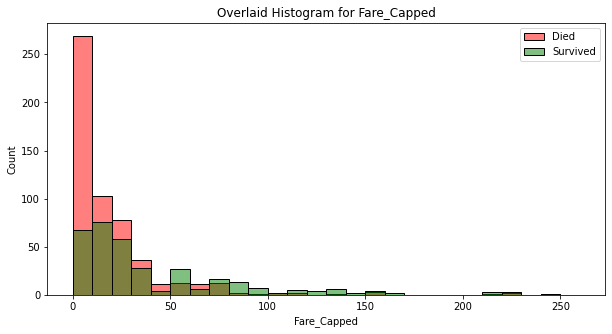

In [1530]:
died = train[train['Survived'] == 0]['Fare_Capped'].dropna()
survived = train[train['Survived'] == 1]['Fare_Capped'].dropna()
xmin = min(min(died), min(survived))
xmax = max(max(died), max(survived))

plt.figure(figsize=(10, 5))
sns.histplot(died, color='r', alpha = 0.5, kde=False, bins=np.arange(xmin, xmax, 10))
sns.histplot(survived, color='g', alpha = 0.5, kde=False, bins=np.arange(xmin, xmax, 10))
plt.legend(['Died', 'Survived'])
plt.title('Overlaid Histogram for Fare_Capped')
plt.show()

- `Age_Capped` appears well-distributed and not in need of transformation
- Generate QQ plots for `Fare_Capped` and histograms to transform data

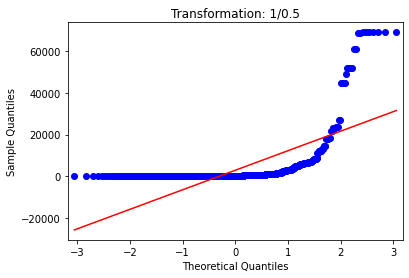

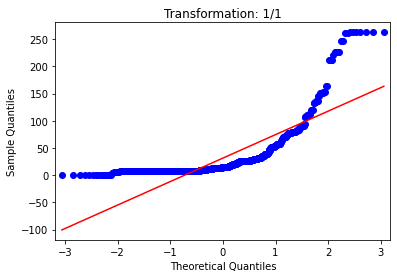

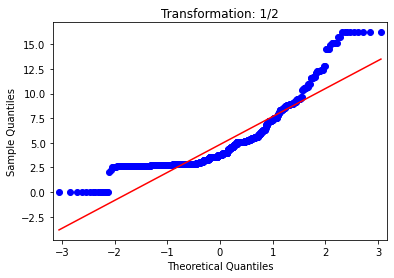

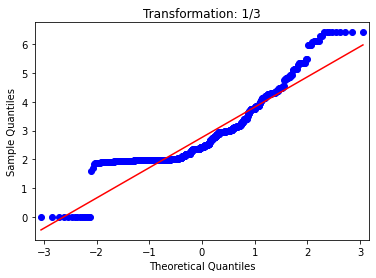

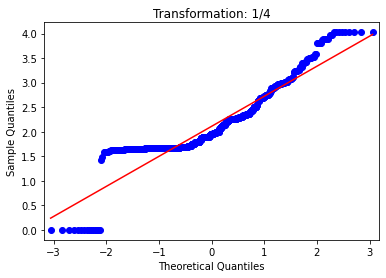

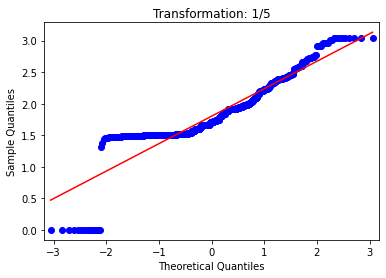

In [1531]:
# generate QQ plots
for i in [0.5, 1, 2, 3, 4, 5]:
    data_t = train['Fare_Capped']**(1/i)
    qqplot(data_t, line='s')
    plt.title("Transformation: 1/{}".format(str(i)))

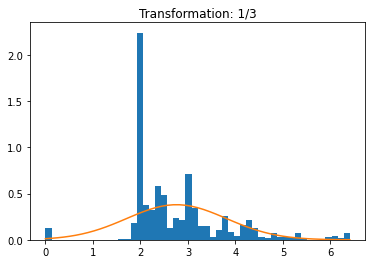

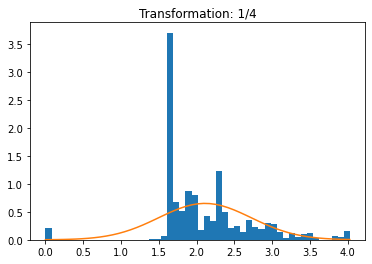

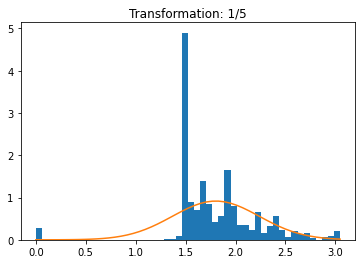

In [1532]:
# Box-Cox transformation, check best fitting QQ plots (1/3, 1/4, 1/5)
for i in [3, 4, 5]:
    data_t = train['Fare_Capped']**(1/i)
    n, bins, patches = plt.hist(data_t, 50, density=True)
    mu = np.mean(data_t)
    sigma = np.std(data_t)
    plt.plot(bins, stats.norm.pdf(bins, mu, sigma))
    plt.title("Transformation: 1/{}".format(str(i)))
    plt.show()

In [1533]:
# create the new transformed feature using x^1/4

# train data
train['Fare_Capped_Transformed'] = train['Fare_Capped'].apply(lambda x: x**(1/4))
# test data
test['Fare_Capped_Transformed'] = test['Fare_Capped'].apply(lambda x: x**(1/4))

# 2) Creating Data Files <a class="anchor" id="creating_data_files"></a>
[To contents](#contents)
- Drop required columns, then write them out to csv for future use
- Split up data for training, validation, and testing

## A) Dropping Columns <a class="anchor" id="dropping_columns"></a>
[To contents](#contents)

In [1534]:
# drop non-numeric and useless features
columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Title', 'Surname', 'TicketPref', 'SurTix', 'IsFamily', 'Child', 'SurvivedDemo', 'FareBin_5']
train = train.drop(columns=columns_to_drop)
test = test.drop(columns=['Survived']+columns_to_drop)

In [1535]:
# what our training data looks like currently
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title_Code,FamilyCount,FamilyId,Family_Matters,FareBin_Code_5,Age_Capped,Fare_Capped,Fare_Capped_Transformed
0,0.0,3,0,22.0,1,0,7.2500,0,0,0,2,0,1,0,22.0,7.2500,1.640909
1,1.0,1,1,38.0,1,0,71.2833,1,1,1,2,0,1,4,38.0,71.2833,2.905674
2,1.0,3,1,26.0,0,0,7.9250,0,0,1,1,0,1,1,26.0,7.9250,1.677837
3,1.0,1,1,35.0,1,0,53.1000,1,0,1,2,0,1,4,35.0,53.1000,2.699440
4,0.0,3,0,35.0,0,0,8.0500,0,0,0,1,0,1,1,35.0,8.0500,1.684414


In [1536]:
# what our testing data looks like currently
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title_Code,FamilyCount,FamilyId,Family_Matters,FareBin_Code_5,Age_Capped,Fare_Capped,Fare_Capped_Transformed
0,3,0,34.5,0,0,7.8292,0,2,0,1,0,1,1,34.5,7.8292,1.672743
1,3,1,47.0,1,0,7.0000,0,0,1,2,0,1,0,47.0,7.0000,1.626577
2,2,0,62.0,0,0,9.6875,0,2,0,1,0,1,1,62.0,9.6875,1.764221
3,3,0,27.0,0,0,8.6625,0,0,0,1,0,1,1,27.0,8.6625,1.715579
4,3,1,22.0,1,1,12.2875,0,0,1,3,32,2,2,22.0,12.2875,1.872259


- Choose final features based on correlation and impact of features
- Eliminate features that have high correlation with each other

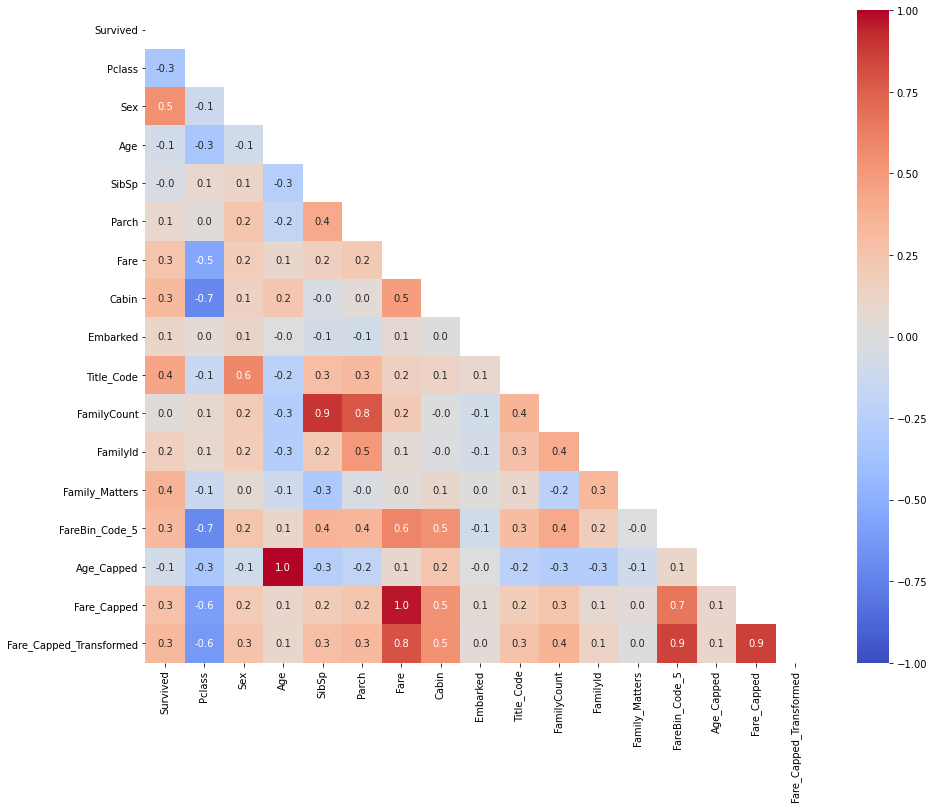

In [1537]:
# generate correlation matrix heat map
plt.figure(figsize = (15,12))
matrix = np.triu(train.corr())
sns.heatmap(train.corr(), annot=True, fmt='.1f', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=matrix);

In [1538]:
# final columns to keep
columns_to_keep = ['Pclass','Title_Code','FamilyCount','FareBin_Code_5','Family_Matters']
train1 = train[['Survived'] + columns_to_keep]
test1 = test[columns_to_keep]

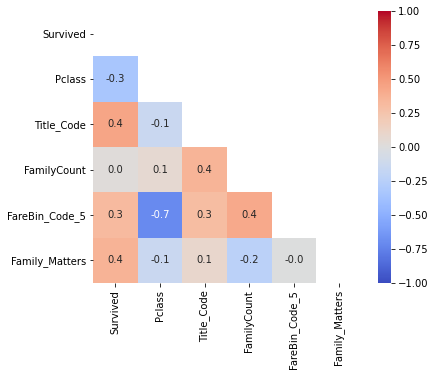

In [1539]:
# generate correlation matrix heat map
plt.figure(figsize = (6,5))
matrix = np.triu(train1.corr())
sns.heatmap(train1.corr(), annot=True, fmt='.1f', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=matrix);

## B) Scaling <a class="anchor" id="scaling"></a>
[To contents](#contents)
- Convert data from raw numbers to z-score (how many standard deviations above the mean)
- Some algorithms, like logistic regression and deep learning algorithms, struggle with unscaled data
- Random forest and gradient boosting does fine with unscaled data, hence commented out

In [1407]:
# # fit the scaler on the training data, then transform
# labels = train1['Survived']
# scaler = StandardScaler()
# scaler.fit(train1)
# features = train1.columns
# train1[features] = scaler.transform(train1[features])
# train1['Survived'] = labels

In [1408]:
# # fit the scaler on the testing data, then transform
# scaler = StandardScaler()
# scaler.fit(test1)
# features = test1.columns
# test1[features] = scaler.transform(test1[features])

In [1409]:
# what our training data looks like currently
train1.head()

,Survived,Pclass,Title_Code,FamilyCount,FareBin_Code_5,Family_Matters
0,0.0,3,0,2,0,1
1,1.0,1,1,2,4,1
2,1.0,3,1,1,1,1
3,1.0,1,1,2,4,1
4,0.0,3,0,1,1,1


In [1410]:
# what our testing data looks like currently
test1.head()

,Pclass,Title_Code,FamilyCount,FareBin_Code_5,Family_Matters
0,3,0,1,1,1
1,3,1,2,0,1
2,2,0,1,1,1
3,3,0,1,1,1
4,3,1,3,2,2


In [1411]:
# write out cleaned data
train1.to_csv('data/train_cleaned.csv', index=False)
test1.to_csv('data/test_cleaned.csv', index=False)

## B) Splitting Up Data <a class="anchor" id="splitting_up_data"></a>
[To contents](#contents)
- Split the training data up into the following segments:
     - Training Data: 60%
     - Validation Data: 20%
     - Test Data: 20%

In [1412]:
train = pd.read_csv('data/train_cleaned.csv')
features = train.drop(columns='Survived')
labels = train['Survived']

# we need to do this twice because train_test_split can only split into two sets
# first put 60% into training
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)
# the put 20% into validation and test, respectively
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# check sizes
for dataset in [y_train, y_val, y_test]:
    print(round(len(dataset) / len(labels), 2))

0.6
0.2
0.2


In [1413]:
# write out split data
X_train.to_csv('data/split/train_features.csv', index=False)
X_val.to_csv('data/split/val_features.csv', index=False)
X_test.to_csv('data/split/test_features.csv', index=False)

y_train.to_csv('data/split/train_labels.csv', index=False)
y_val.to_csv('data/split/val_labels.csv', index=False)
y_test.to_csv('data/split/test_labels.csv', index=False)

# 3) Training Models <a class="anchor" id="training_models"></a>
[To contents](#contents)
- Use the training dataset using 5-Fold Cross-Validaiton to get a basic idea of the model's performance
- 5-Fold Cross-Validation shows the accuracy of the model when training on different subsets of the data

In [1414]:
# read in data
X_train = pd.read_csv('data/split/train_features.csv')
X_val = pd.read_csv('data/split/val_features.csv')
X_test = pd.read_csv('data/split/test_features.csv')

y_train = pd.read_csv('data/split/train_labels.csv')
y_val = pd.read_csv('data/split/val_labels.csv')
y_test = pd.read_csv('data/split/test_labels.csv')

In [1415]:
# prints results of GridSearchCV
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))
    
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        # prints mean and 2 standard deviations to each side
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

## A) Logistic Regression <a class="anchor" id="logistic_regression"></a>
[To contents](#contents)
- Regression is a statistical process for estimating relationships among variables
- Logistic regression uses a logistic function (sigmoid curve) to model a binary variable
- When to use
    - Categorical target variable
    - Transparency is important
    - Fairly well-behaved data
    - Need a quick benchmark
- When not to use
    - Continuous target variable
    - Massive data (rows or columns)
    - Messy data with many outliers
    - Performance matters most
- Key hyperparameters
    - `C = 1/lambda` 
    - `lambda` is a regularization parameter that controls overfitting and underfitting
    - High `lambda` = low `C` -> low regularization, more likely overfit 
    - Low `lambda` = high `C` -> high regularization, more likely underfit   

In [1416]:
# view parameters
LogisticRegression()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [1417]:
# fit model
lr = LogisticRegression()
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

cv1 = GridSearchCV(lr, parameters, cv=5)
cv1.fit(X_train, y_train.values.ravel())

print_results(cv1)

BEST PARAMS: {'C': 1}

0.624 (+/-0.007) for {'C': 0.001}
0.747 (+/-0.071) for {'C': 0.01}
0.822 (+/-0.087) for {'C': 0.1}
0.852 (+/-0.066) for {'C': 1}
0.846 (+/-0.067) for {'C': 10}
0.846 (+/-0.067) for {'C': 100}
0.846 (+/-0.067) for {'C': 1000}


In [1418]:
# save model
joblib.dump(cv1.best_estimator_, 'models/selection/logistic_regression.pkl')

['models/selection/logistic_regression.pkl']

## B) Support Vector Machine<a class="anchor" id="support_vector_machine"></a>
[To contents](#contents)
- Support vector machine is a classifier that finds an optimal hyperplane that maximizes margin between two classes
- Support vector is the perpendicular line from decision boundary to closest points in each class
- Hyperplane is decision boundary in n-dimensional space
- Kernel trick transforms data not linearly separable in n-dimensional space to a higher dimension where it is linearly separable
- When to use
    - Categorical target variable
    - High feature-to-row ratio
    - Complex relationships
    - Data with many outliers
- When not to use
    - Low feature-to-row ratio
    - Transparency is important
    - Need a quick benchmark
- Key hyperparameters
    - Low `C` -> high regularization, small penalty for misclassification, large margin, more likely underfit 
    - High `C` -> low regularization, large penalty for misclassification, small margin, more likely overfit
    - `kernel` controls kernel trick method

In [1419]:
# view parameters
SVC()

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [1420]:
# fit model
svc = SVC()
parameters = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10]
}

cv2 = GridSearchCV(svc, parameters, cv=5)
cv2.fit(X_train, y_train.values.ravel())

print_results(cv2)

BEST PARAMS: {'C': 1, 'kernel': 'rbf'}

0.83 (+/-0.066) for {'C': 0.1, 'kernel': 'linear'}
0.807 (+/-0.104) for {'C': 0.1, 'kernel': 'rbf'}
0.837 (+/-0.067) for {'C': 1, 'kernel': 'linear'}
0.846 (+/-0.067) for {'C': 1, 'kernel': 'rbf'}
0.837 (+/-0.067) for {'C': 10, 'kernel': 'linear'}
0.841 (+/-0.045) for {'C': 10, 'kernel': 'rbf'}


In [1421]:
# save model
joblib.dump(cv2.best_estimator_, 'models/selection/support_vector_machine.pkl')

['models/selection/support_vector_machine.pkl']

## C) Multilayer Perceptron <a class="anchor" id="multilayer_perceptron"></a>
[To contents](#contents)
- Multilayer perceptron is a classic feed-forward artificial neural network
- Connected series of nodes, each node represents a function
- Input layer, hidden layers, output layer
- When to use
    - Categorical or continuous target variable
    - Complex relationships
    - Control over training process, many hyperparameters
- When not to use
    - Image recognition, time series, etc
    - Transparency is important
    - Need a quick benchmark
- Key hyperparameters
    - `hidden_layer_sizes` determines how many layers and how many nodes in each layer
    - `learning_rate` facilitates how quickly and whether or not algorithm will find optimal solution, select a type of learning
        - Low learning rate is slow and may get stuck in local min
        - High learning rate jumps around and may never find optimal solution
    - `activation function` transforms inputs, includes sigmoid, tanh, ReLU

In [1422]:
# view parameters
print(MLPRegressor())
print(MLPClassifier())

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, ver

In [1423]:
# fit model
mlp = MLPClassifier()
parameters = {
    'hidden_layer_sizes': [(16, 16 ,16), (32,32), (64,64)],
    'activation': ['relu', 'tanh', 'logistic'],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

cv3 = GridSearchCV(mlp, parameters, cv=5)
cv3.fit(X_train, y_train.values.ravel())

print_results(cv3)

BEST PARAMS: {'activation': 'relu', 'hidden_layer_sizes': (64, 64), 'learning_rate': 'adaptive'}

0.833 (+/-0.058) for {'activation': 'relu', 'hidden_layer_sizes': (16, 16, 16), 'learning_rate': 'constant'}
0.852 (+/-0.057) for {'activation': 'relu', 'hidden_layer_sizes': (16, 16, 16), 'learning_rate': 'invscaling'}
0.845 (+/-0.063) for {'activation': 'relu', 'hidden_layer_sizes': (16, 16, 16), 'learning_rate': 'adaptive'}
0.85 (+/-0.061) for {'activation': 'relu', 'hidden_layer_sizes': (32, 32), 'learning_rate': 'constant'}
0.852 (+/-0.064) for {'activation': 'relu', 'hidden_layer_sizes': (32, 32), 'learning_rate': 'invscaling'}
0.848 (+/-0.072) for {'activation': 'relu', 'hidden_layer_sizes': (32, 32), 'learning_rate': 'adaptive'}
0.848 (+/-0.064) for {'activation': 'relu', 'hidden_layer_sizes': (64, 64), 'learning_rate': 'constant'}
0.848 (+/-0.052) for {'activation': 'relu', 'hidden_layer_sizes': (64, 64), 'learning_rate': 'invscaling'}
0.856 (+/-0.072) for {'activation': 'relu', '

In [1424]:
# save model
joblib.dump(cv3.best_estimator_, 'models/selection/multilayer_perceptron.pkl')

['models/selection/multilayer_perceptron.pkl']

## D) Random Forest<a class="anchor" id="random_forest"></a>
[To contents](#contents)
- Random forest merges a collection of independent decision trees to get a more acurate and stable predictino
- Type of ensemble method, which combies multiple models to reduce bias and variance
- Splits training data into several data samples and feature samples
- Each tree gives a prediction, takes majority or average result
- When to use
    - Categorical or continuous target variable
    - Interested in significance of predictors
    - Need a quick benchmark
    - Messy data with many missig values and outliers
- When not to use
    - Transparency is important
    - Complex relationships
    - Prediction time is important
- Key hyperparameters
    - `n_estimators` controls how many individual decision trees are built
    - `max_depth` controls how deep each tree can go

In [1440]:
# view parameters
print(RandomForestClassifier())
print(RandomForestRegressor())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      rand

In [1448]:
# fit model
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [25, 50, 100, 250],
    'max_depth': [8, 16, 32, None]
}

cv4 = GridSearchCV(rf, parameters, cv=5)
cv4.fit(X_train, y_train.values.ravel())

print_results(cv4)

BEST PARAMS: {'max_depth': 16, 'n_estimators': 100}

0.846 (+/-0.053) for {'max_depth': 8, 'n_estimators': 25}
0.845 (+/-0.057) for {'max_depth': 8, 'n_estimators': 50}
0.843 (+/-0.046) for {'max_depth': 8, 'n_estimators': 100}
0.843 (+/-0.046) for {'max_depth': 8, 'n_estimators': 250}
0.841 (+/-0.059) for {'max_depth': 16, 'n_estimators': 25}
0.843 (+/-0.046) for {'max_depth': 16, 'n_estimators': 50}
0.848 (+/-0.059) for {'max_depth': 16, 'n_estimators': 100}
0.845 (+/-0.043) for {'max_depth': 16, 'n_estimators': 250}
0.839 (+/-0.054) for {'max_depth': 32, 'n_estimators': 25}
0.845 (+/-0.057) for {'max_depth': 32, 'n_estimators': 50}
0.845 (+/-0.058) for {'max_depth': 32, 'n_estimators': 100}
0.846 (+/-0.05) for {'max_depth': 32, 'n_estimators': 250}
0.845 (+/-0.057) for {'max_depth': None, 'n_estimators': 25}
0.846 (+/-0.042) for {'max_depth': None, 'n_estimators': 50}
0.843 (+/-0.052) for {'max_depth': None, 'n_estimators': 100}
0.843 (+/-0.046) for {'max_depth': None, 'n_estimators

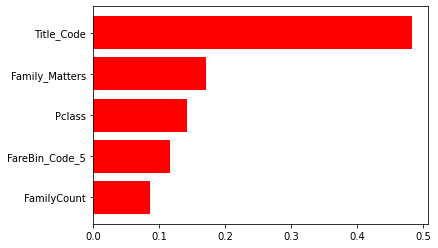

In [1449]:
# generate feature importance plot
feat_imp = cv4.best_estimator_.feature_importances_
indices = np.argsort(feat_imp)
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.barh(range(len(indices)), feat_imp[indices], color='r', align='center')
plt.show()

In [1450]:
# save model
joblib.dump(cv4.best_estimator_, 'models/selection/random_forest.pkl')

['models/selection/random_forest.pkl']

## E) Gradient Boosting<a class="anchor" id="gradient_boosting"></a>
[To contents](#contents)
- Gradient boosting aggregates many weak models, learning from its own mistakes with each iteration to create one strong model
- Type of ensemble method, which combies multiple models to reduce bias and variance
- Takes sample from training data classifies examples, next model overweights misclassified examples from previous model
- Final selection based on weighted voting based on how well each model did in training
- When to use
    - Categorical or continuous target variable
    - Interested in significance of predictors
    - Prediction time is important
- When not to use
    - Transparency is important
    - Data is very noisy, boosting tends to overfit
    - Training time is important
- Key hyperparameters
    - `n_estimators` controls how many individual decision trees are built (should be more than random forest)
    - `max_depth` controls how deep each tree can go (should be shallower than random forest)
    - `learning_rate` facilitates how quickly and whether or not algorithm will find optimal solution, select a numerical value
        - Low learning rate is slow and may get stuck in local min
        - High learning rate jumps around and may never find optimal solution

In [1451]:
# view parameters
print(GradientBoostingClassifier())
print(GradientBoostingRegressor())

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, random_state=None,
                           subsample=1.0, tol=0.0001, validation_fraction=0.1,
                           verbose=0, warm_start=False)
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_

In [1452]:
# fit model
gb = GradientBoostingClassifier()
parameters = {
    'n_estimators': [50, 250, 500],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.05, 0.2, 0.5, 1]
}

cv5 = GridSearchCV(gb, parameters, cv=5)
cv5.fit(X_train, y_train.values.ravel())

print_results(cv5)

BEST PARAMS: {'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 50}

0.854 (+/-0.064) for {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 50}
0.854 (+/-0.064) for {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 250}
0.848 (+/-0.066) for {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500}
0.832 (+/-0.075) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.848 (+/-0.069) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}
0.85 (+/-0.059) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
0.845 (+/-0.073) for {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 50}
0.843 (+/-0.055) for {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 250}
0.845 (+/-0.049) for {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}
0.854 (+/-0.064) for {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 50}
0.848 (+/-0.049) for {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 250}
0.846 (+/-0.051) for {'learnin

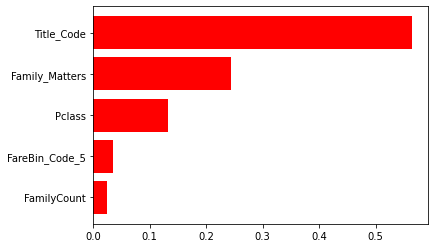

In [1453]:
# generate feature importance plot
feat_imp = cv5.best_estimator_.feature_importances_
indices = np.argsort(feat_imp)
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.barh(range(len(indices)), feat_imp[indices], color='r', align='center')
plt.show()

In [1454]:
# save model
joblib.dump(cv5.best_estimator_, 'models/selection/gradient_boosting.pkl')

['models/selection/gradient_boosting.pkl']

# 4) Model Selection<a class="anchor" id="model_selection"></a>
[To contents](#contents)
![Comparison](model_comparison.png)

In [1455]:
# create dictionary of models
models = {}
for mdl in ['logistic_regression', 'support_vector_machine', 'multilayer_perceptron', 'random_forest', 'gradient_boosting']:
    models[mdl] = joblib.load('models/selection/{}.pkl'.format(mdl))

## A) Evaluation Statistics<a class="anchor" id="evaluation_statistics"></a>
[To contents](#contents)
- Accuracy = # predicted correctly/total # examples
- Precision = # predicted to survive that actually survived / total # predicted to survive
- Recall = # predicted to survive that actually survived / total # that actually survived

In [1456]:
# evaluates prediction time, accuracy, precision, recall
def evaluate_model(name, model, features, labels):
    start = time()
    pred = model.predict(features)
    end = time()
    accuracy = round(accuracy_score(labels, pred), 3)
    precision = round(precision_score(labels, pred), 3)
    recall = round(recall_score(labels, pred), 3)
    print('{} -- Accuracy: {} / Precision: {} / Recall: {} / Latency: {}ms'.format(name,
                                                                                   accuracy,
                                                                                   precision,
                                                                                   recall,
                                                                                   round((end - start)*1000, 1)))

In [1458]:
# test on validation set
for name, mdl in models.items():
    evaluate_model(name, mdl, X_val, y_val)

logistic_regression -- Accuracy: 0.838 / Precision: 0.841 / Recall: 0.763 / Latency: 1.6ms
support_vector_machine -- Accuracy: 0.855 / Precision: 0.868 / Recall: 0.776 / Latency: 6.1ms
multilayer_perceptron -- Accuracy: 0.821 / Precision: 0.855 / Recall: 0.697 / Latency: 1.7ms
random_forest -- Accuracy: 0.821 / Precision: 0.867 / Recall: 0.684 / Latency: 12.5ms
gradient_boosting -- Accuracy: 0.827 / Precision: 0.857 / Recall: 0.711 / Latency: 1.5ms


In [1459]:
# final evaluation of best model on test set
evaluate_model('gradient_boosting', models['gradient_boosting'], X_test, y_test)

gradient_boosting -- Accuracy: 0.815 / Precision: 0.786 / Recall: 0.677 / Latency: 2.3ms


# 5) Final Training and Submission<a class="anchor" id="final_training_and_submission"></a>
[To contents](#contents)
- Train the model on the entire training set and create a submission
- Normally, you would select the best model from our validation evaluations (random forest) to submit
- Out of curiousity, I will try all models :)

In [1462]:
# import all cleaned data
train_cleaned = pd.read_csv('data/train_cleaned.csv')
test_cleaned = pd.read_csv('data/test_cleaned.csv')

features = train_cleaned.drop(columns='Survived')
labels = train_cleaned['Survived'].values.ravel()

In [1463]:
# fit on complete training data
final_lr = LogisticRegression(C=1)
final_lr.fit(features, labels)
joblib.dump(final_lr, 'models/final/logistic_regression.pkl')

final_svm = SVC(C=1, kernel='rbf')
final_svm.fit(features, labels)
joblib.dump(final_svm, 'models/final/support_vector_machine.pkl')

final_mlp = MLPClassifier(activation='relu', hidden_layer_sizes=(64, 64), learning_rate='adaptive')
final_mlp.fit(features, labels)
joblib.dump(final_mlp, 'models/final/multilayer_perceptron.pkl')

final_rf = RandomForestClassifier(max_depth=16, n_estimators=100)
final_rf.fit(features, labels)
joblib.dump(final_rf, 'models/final/random_forest.pkl')

final_gb = GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=50)
final_gb.fit(features, labels)
joblib.dump(final_gb, 'models/final/gradient_boosting.pkl')

['models/final/gradient_boosting.pkl']

In [1464]:
# create dictionary of models
final_models = {}
for mdl in ['logistic_regression', 'support_vector_machine', 'multilayer_perceptron', 'random_forest', 'gradient_boosting']:
    final_models[mdl] = joblib.load('models/final/{}.pkl'.format(mdl))

In [1465]:
# write out submission
ids = pd.read_csv('data/test.csv')['PassengerId']
def submission(name, model):
    predictions = model.predict(test_cleaned)
    predictions = predictions.astype(int)
    output = pd.DataFrame({'PassengerId' : ids, 'Survived': predictions})
    output.to_csv('submissions/{}_submission.csv'.format(name), index = False)
    
for name, mdl in final_models.items():
    submission(name, mdl)

# 6) Results<a class="anchor" id="results"></a>
[To contents](#contents)
- Logistic Regression: 0.79904
- Support Vector Machine: 0.79904
- Multilayer Perceptron: 0.80382
- Random Forest: 0.80861
- Gradient Boosting: 0.80861

The best model was random forest. As of January 2022, it placed 362/13438, or top 2.69%. Excluding perfect scores which are a result of cheating, it would place 196/13272, or top 1.47%.